# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [57]:
# %pip install tensorflow --upgrade
# %pip install keras --upgrade
# %pip install scikit-image
import numpy as np
import seaborn as sns
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras import layers

%matplotlib inline

Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [44]:
n_orientations = 8
pix_p_cell = 2
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [45]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

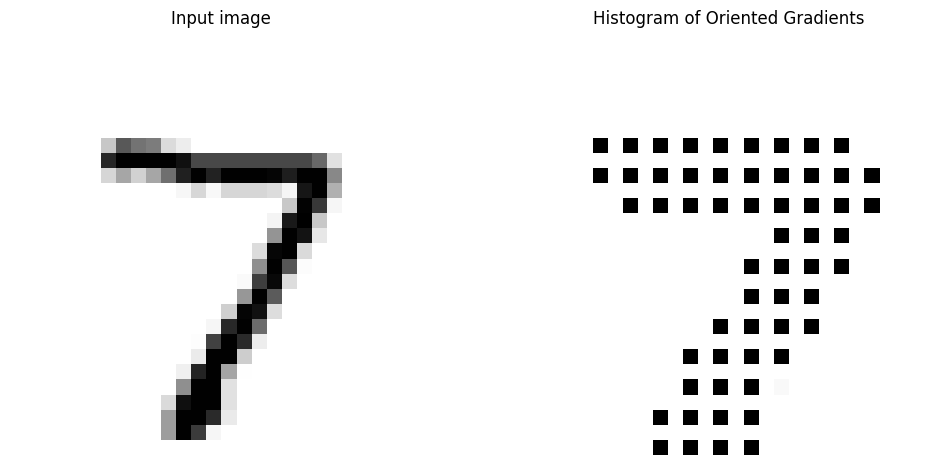

In [46]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets


In [47]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [62]:
model = Sequential()
model.add(Dense(2, input_shape=(hog_size,), activation='relu'))
model.add(Dense(8, input_shape=(hog_size,), activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 2)              │         3,138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,252 (12.70 KB)

 Trainable params: 3,252 (12.70 KB)

 Non-trainable params: 0 (0.00 B)

Define some constants and train the MLP

In [63]:
batch_size = 128
n_epoch = 80

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2195 - loss: 2.0113 - val_accuracy: 0.5443 - val_loss: 1.2049
Epoch 2/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5685 - loss: 1.1163 - val_accuracy: 0.6922 - val_loss: 0.8609
Epoch 3/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.7103 - loss: 0.8521 - val_accuracy: 0.7458 - val_loss: 0.7344
Epoch 4/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.7472 - loss: 0.7435 - val_accuracy: 0.7800 - val_loss: 0.6643
Epoch 5/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.7713 - loss: 0.6801 - val_accuracy: 0.7995 - val_loss: 0.6193
Epoch 6/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7923 - loss: 0.6430 - val_accuracy: 0.8158 - val_loss: 0.5904
Epoch 7/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.8086 - loss: 0.6173 - val_accuracy: 0.8287 - val_loss: 0.5665
Epoch 8/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.8183 - loss: 0.5933 - val_

Show the performance of the model

Test score: 0.44927549362182617
Test accuracy: 0.8586000204086304


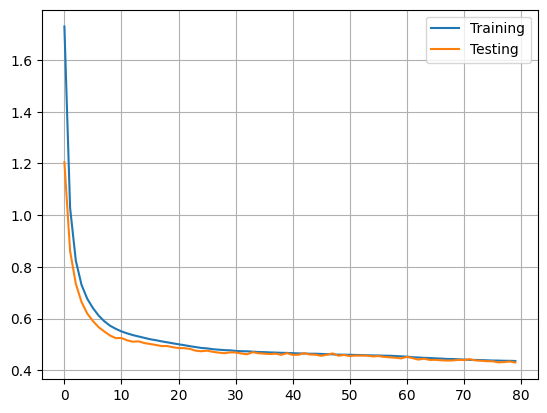

In [64]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


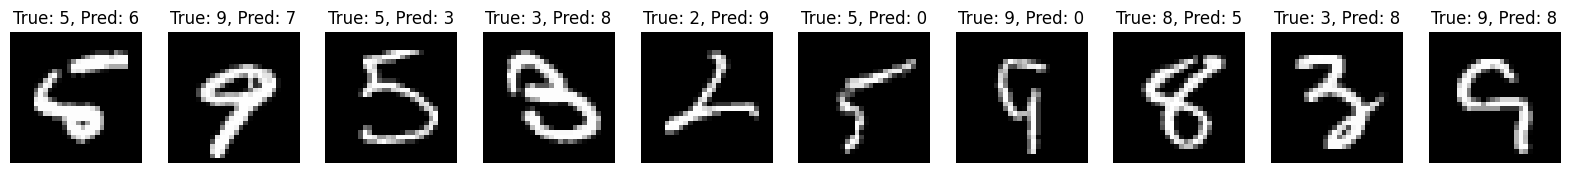

In [66]:
# Function to plot misclassified images
def plot_misclassified_images(X_orig, y_true, y_pred, class_names, max_images=10):
    misclassified_indices = np.where(y_pred != y_true)[0]
    num_misclassified = len(misclassified_indices)
    
    if num_misclassified > 0:
        fig, axes = pl.subplots(1, min(max_images, num_misclassified), figsize=(20, 4))
        for ax, index in zip(axes.flat, misclassified_indices[:max_images]):
            # Use original images for visualization
            ax.imshow(X_orig[index].reshape(28, 28), cmap='gray', interpolation='none')
            ax.set_title(f"True: {class_names[y_true[index]]}, Pred: {class_names[y_pred[index]]}")
            ax.axis('off')
        pl.show()
    else:
        print("No misclassified images to show.")

# Predict the labels on the test dataset
y_pred_prob = model.predict(X_test_hog)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

# Plot misclassified images
plot_misclassified_images(X_test.squeeze(), y_true_classes, y_pred_classes, class_names=[str(i) for i in range(10)])


Confusion matrix

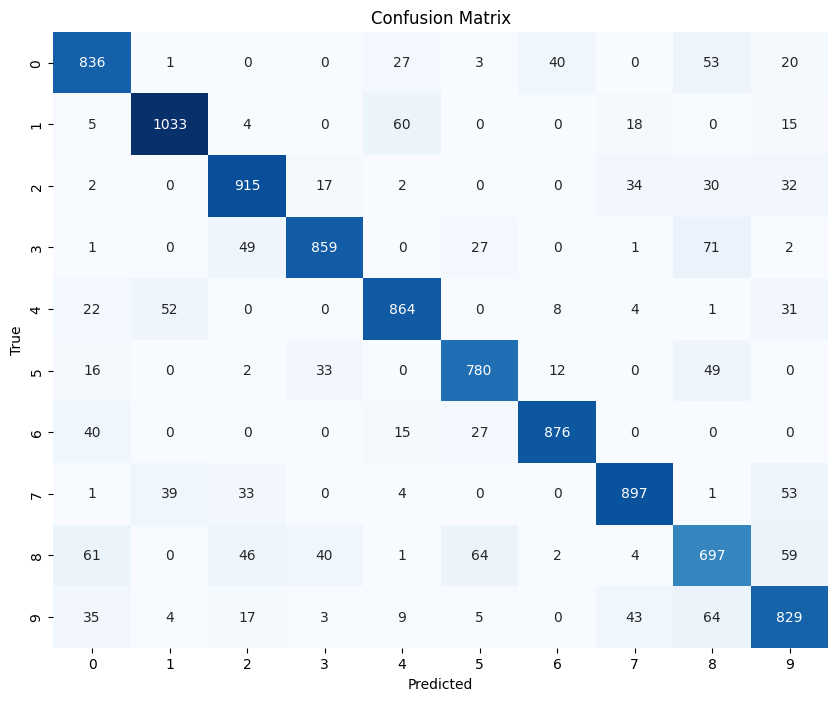

Digit Accuracies from Most to Least Accurate:
Digit 6: 91.44%
Digit 1: 91.01%
Digit 2: 88.66%
Digit 4: 87.98%
Digit 5: 87.44%
Digit 7: 87.26%
Digit 0: 85.31%
Digit 3: 85.05%
Digit 9: 82.16%
Digit 8: 71.56%


In [68]:
# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_prob, axis=-1)

# Compute confusion matrix 
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting using seaborn
pl.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
pl.xlabel('Predicted')
pl.ylabel('True')
pl.title('Confusion Matrix')
pl.show()

# Calculate classification accuracy for each digit
accuracies = cm.diagonal() / cm.sum(axis=1)
digits = np.arange(len(cm))

# Pair each digit with its accuracy and sort by accuracy
digit_accuracies = sorted(zip(digits, accuracies), key=lambda x: x[1], reverse=True)

# Print sorted accuracies
print("Digit Accuracies from Most to Least Accurate:")
for digit, accuracy in digit_accuracies:
    print(f"Digit {digit}: {accuracy*100:.2f}%")